In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss, adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

import pmdarima as pm

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\mimam\AppData\Local\Temp\ipykernel_7004\3591705886.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('./store5.csv')
data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [3]:
data['dcoilwtico'] = data['dcoilwtico'].ffill()
data['dcoilwtico'] = data['dcoilwtico'].bfill()
data['dcoilwtico'].isnull().sum()

0

In [4]:
eggs = data.loc[data['family'] == 'EGGS']
eggs = eggs.drop(columns = ['id', 'store_nbr', 'family'])
eggs['date'] = pd.to_datetime(eggs['date'])
eggs = eggs.set_index('date')
eggs

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,0.0,0,93.14
2013-01-02,246.0,0,93.14
2013-01-03,120.0,0,92.97
2013-01-04,141.0,0,93.12
2013-01-05,143.0,0,93.12
...,...,...,...
2017-08-11,95.0,24,48.81
2017-08-12,77.0,0,48.81
2017-08-13,100.0,0,48.81


# Heatmap Correlation

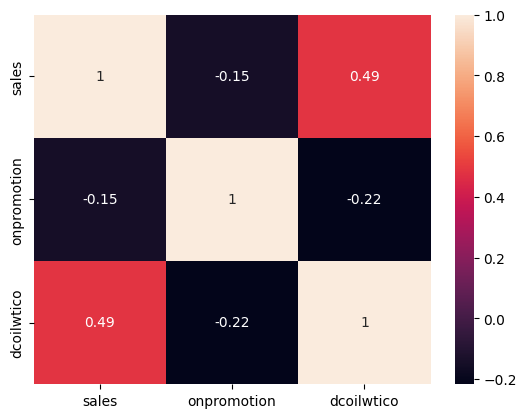

In [5]:
correlation = eggs[['sales', 'onpromotion', 'dcoilwtico']]
correlation = correlation.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)
plt.show()

# ADF & KPSS Test

In [6]:
def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print('ADF Test: Sales time series')
adf_test(eggs['sales'])
print('ADF Test: Onpromotion time series')
adf_test(eggs['onpromotion'])
print('ADF Test: Tesla time series')
adf_test(eggs['dcoilwtico'])

ADF Test: Sales time series
ADF Statistics: -1.860447
p-value: 0.350891
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Onpromotion time series
ADF Statistics: -2.032584
p-value: 0.272471
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Tesla time series
ADF Statistics: -0.879185
p-value: 0.794750
	1%: -3.434
	5%: -2.863
	10%: -2.568


Semua time series memilikki p-value diatas 0.05, yang berarti time series tidak stasioner

In [7]:
def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: sales time series')
kpss_test(eggs['sales'])
print('KPSS Test: onpromotion time series')
kpss_test(eggs['onpromotion'])
print('KPSS Test: dcoilwtico time series')
kpss_test(eggs['dcoilwtico'])

KPSS Test: sales time series
KPSS Statistic: 6.67361288050656
p-value: 0.01
num lags: 21
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: onpromotion time series
KPSS Statistic: 2.6406168808649944
p-value: 0.01
num lags: 40
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: dcoilwtico time series
KPSS Statistic: 5.063232436812116
p-value: 0.01
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


Semua time series memilikki p-value dibawah 0.05, yang berarti time series tidak stasioner karena terdapat unit root

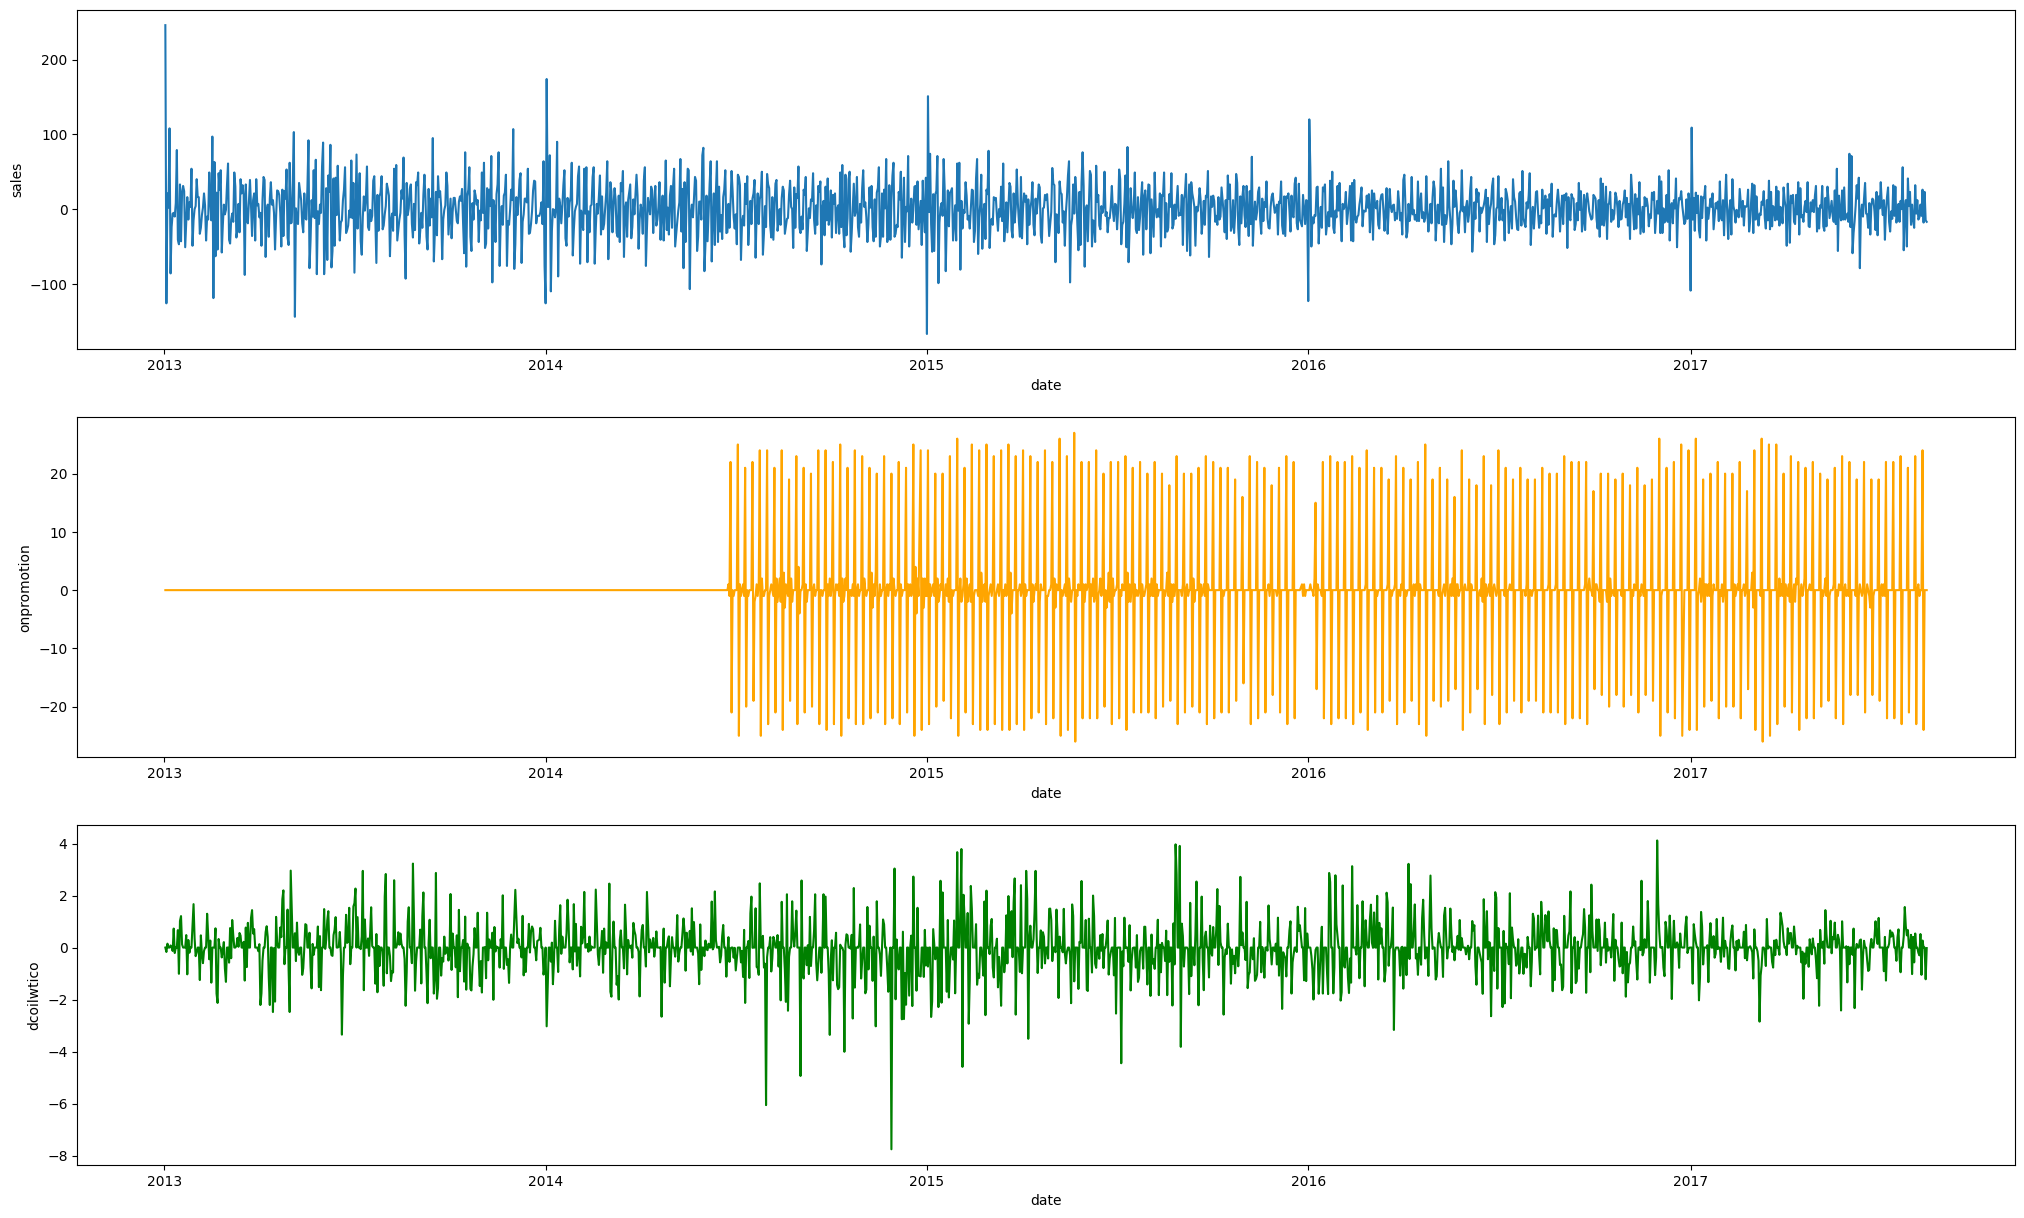

In [8]:
eggs_diff = eggs.diff().dropna()

fig, ax = plt.subplots(3, 1, figsize = (25, 15))

sns.lineplot(data = eggs_diff['sales'], ax = ax[0])
sns.lineplot(data = eggs_diff['onpromotion'], ax = ax[1], color = 'orange')
sns.lineplot(data = eggs_diff['dcoilwtico'], ax = ax[2], color = 'green')

plt.show()

In [9]:
print('ADF Test: Sales time series')
adf_test(eggs_diff['sales'])
print('ADF Test: Onpromotion time series')
adf_test(eggs_diff['onpromotion'])
print('ADF Test: Tesla time series')
adf_test(eggs_diff['dcoilwtico'])

ADF Test: Sales time series
ADF Statistics: -12.485285
p-value: 0.000000
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Onpromotion time series
ADF Statistics: -11.969937
p-value: 0.000000
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Tesla time series
ADF Statistics: -43.399189
p-value: 0.000000
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [10]:
print('KPSS Test: sales time series')
kpss_test(eggs_diff['sales'])
print('KPSS Test: onpromotion time series')
kpss_test(eggs_diff['onpromotion'])
print('KPSS Test: dcoilwtico time series')
kpss_test(eggs_diff['dcoilwtico'])

KPSS Test: sales time series
KPSS Statistic: 0.1415519052324898
p-value: 0.1
num lags: 56
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: onpromotion time series
KPSS Statistic: 0.18813449163464704
p-value: 0.1
num lags: 610
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: dcoilwtico time series
KPSS Statistic: 0.16434989819134885
p-value: 0.1
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


Setelah dilakukan differencing, dari hasil tes ADF & KPSS menunjukkan bahwa time series sudah stasioner 

# VAR modelling

In [11]:
model = VAR(eggs_diff)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  11.126438536824477
BIC :  11.165162000609492
FPE :  67943.96251282326
HQIC:  11.140781768464226 

Lag Order = 2
AIC :  10.829471050354064
BIC :  10.897269995506699
FPE :  50487.00193831039
HQIC:  10.854584637169943 

Lag Order = 3
AIC :  10.650843693521564
BIC :  10.747746355528658
FPE :  42228.22500053201
HQIC:  10.686738739671842 

Lag Order = 4
AIC :  10.402597930249634
BIC :  10.528632589347922
FPE :  32945.134260275416
HQIC:  10.449285557991255 

Lag Order = 5
AIC :  10.125171915048082
BIC :  10.280366896321802
FPE :  24963.59016810108
HQIC:  10.182663264776817 

Lag Order = 6
AIC :  7.432098087679203
BIC :  7.6164817611579885
FPE :  1689.353172611029
HQIC:  7.500404317969941 

Lag Order = 7
AIC :  7.40845036889756
BIC :  7.622051149654585
FPE :  1649.875142599925
HQIC:  7.487582656544689 

Lag Order = 8
AIC :  7.4102267567557565
BIC :  7.653073105006167
FPE :  1652.8120804146438
HQIC:  7.500196296813673 

Lag Order = 9
AIC :  7.417979040087657
BIC :  7.690099

AIC terendah terletak pada lag ke-12

In [12]:
results = model.fit(maxlags=12, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Mar, 2024
Time:                     10:45:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.76126
Nobs:                     1671.00    HQIC:                   7.53458
Log likelihood:          -13185.8    FPE:                    1637.90
AIC:                      7.40115    Det(Omega_mle):         1533.74
--------------------------------------------------------------------
Results for equation sales
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.257648         0.521807           -0.494           0.621
L1.sales               -0.727541         0.024483          -29.716           0.000
L1.onpromotion          0.309264         0.291236   

- onpromotion terhadap sales = 0.1
- dcoilwtico terhadap sales = 0.03

onpromotion mempunyai korelasi terbesar terhadap sales

# Durbin-Watson Statistic

In [13]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(eggs_diff.columns, out):
    print(col, ':', round(val, 2))

sales : 2.09
onpromotion : 2.0
dcoilwtico : 2.0


Value menunjukkan nilai 2.0 yang berarti tidak ada autokorelasi pada residu

# Granger Causality Test

In [14]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(eggs_diff, variables = eggs_diff.columns)

,sales_x,onpromotion_x,dcoilwtico_x
sales_y,1.0000,0.0000,0.1010
onpromotion_y,0.0000,1.0000,0.1882
dcoilwtico_y,0.0121,0.2391,1.0000


- onpromotion granger causes sales (p-value below 0.05)
- dcoilwtico not granger causes sales (p-value above 0.05)

# SARIMAX Modelling

In [26]:
train = eggs_diff[:len(eggs)-30]
test = eggs_diff[len(eggs)-30:]
# model_sarimax1 = ARIMA(train['sales'], order=(2,1,1), seasonal_order=(1,1,2,7), exog=train['onpromotion']) 15103
# model_sarimax1 = ARIMA(train['sales'], order=(2,1,2), seasonal_order=(2,1,2,7), exog=train['onpromotion']) 14762
# model_sarimax1 = ARIMA(train['sales'], order=(2,1,2), seasonal_order=(3,1,2,7), exog=train['onpromotion']) 14748

model_sarimax1 = ARIMA(train['sales'], order=(2,1,2), seasonal_order=(3,1,2,7), exog=train['onpromotion'])
model_sarimax1_fit = model_sarimax1.fit()
print(model_sarimax1_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(3, 1, 2)x(3, 1, 2, 7)   Log Likelihood               -7478.146
Date:                         Fri, 15 Mar 2024   AIC                          14980.291
Time:                                 10:48:25   BIC                          15045.164
Sample:                                      0   HQIC                         15004.346
                                        - 1654                                         
Covariance Type:                           opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion     0.8944      0.155      5.773      0.000       0.591       1.198
ar.L1           0.0908      0.023      3.891      0.000 

In [16]:
model_sarimax2 = ARIMA(train['sales'], order=(2,1,2), seasonal_order=(3,1,2,7), exog=train['dcoilwtico'])
model_sarimax2_fit = model_sarimax2.fit()
print(model_sarimax2_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(2, 1, 2)x(3, 1, 2, 7)   Log Likelihood               -7400.588
Date:                         Fri, 15 Mar 2024   AIC                          14823.177
Time:                                 10:46:23   BIC                          14882.644
Sample:                                      0   HQIC                         14845.227
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dcoilwtico     0.4361      0.200      2.183      0.029       0.044       0.828
ar.L1          0.1611      0.017      9.295      0.000     

# Residual Plot

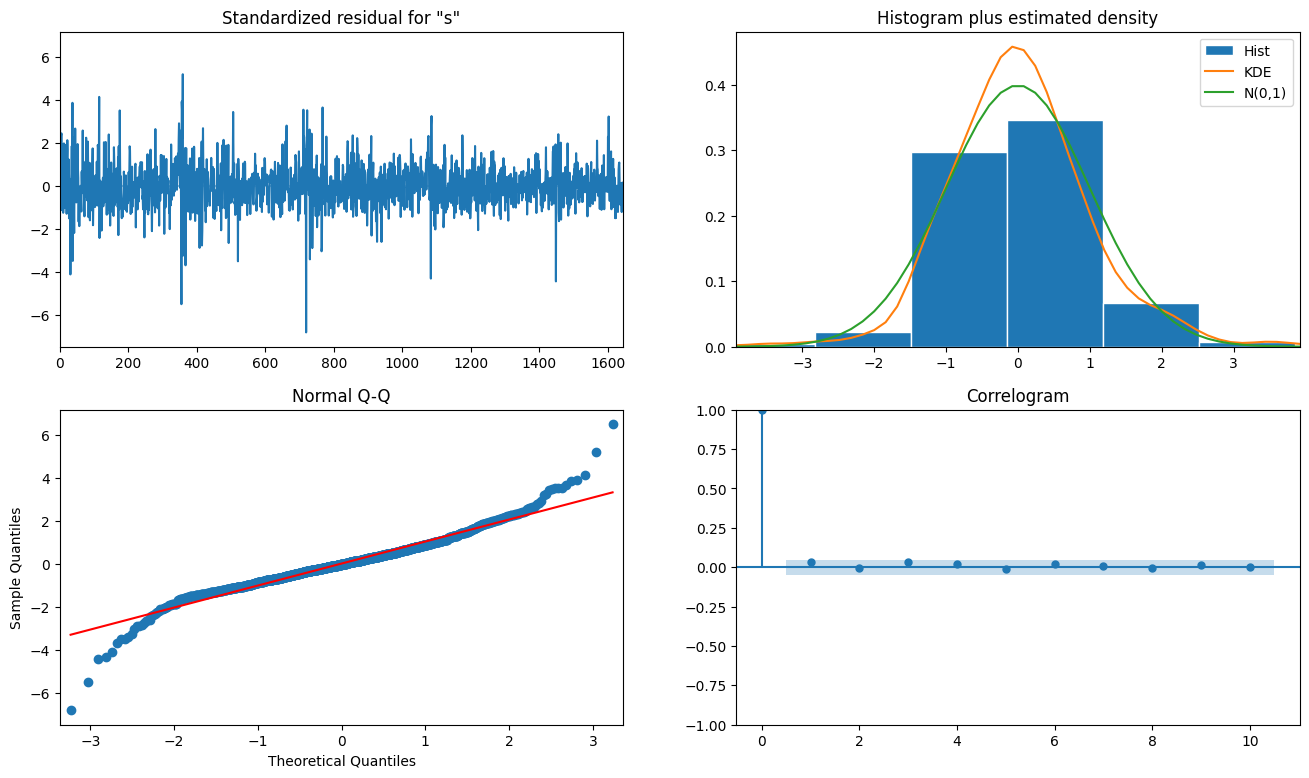

In [17]:
# Plot diagnostics
model_sarimax1_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

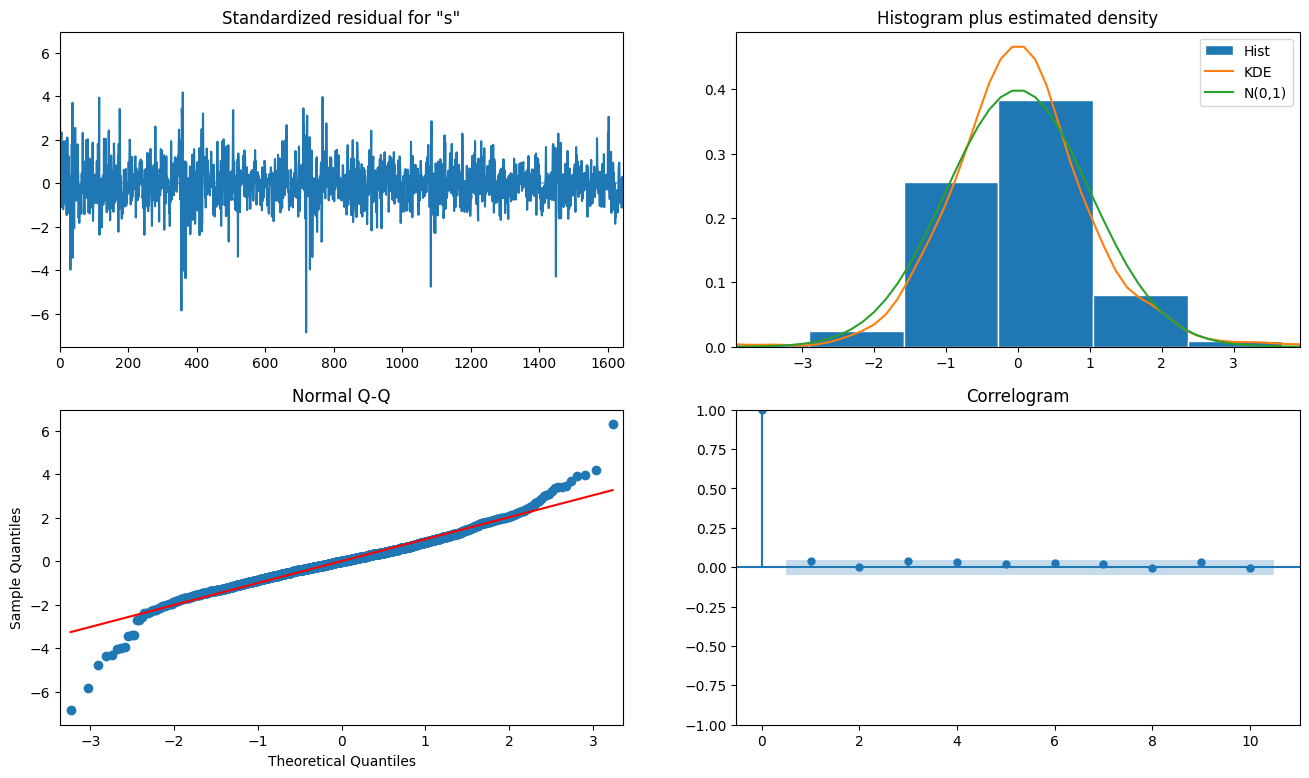

In [18]:
# Plot diagnostics
model_sarimax2_fit.plot_diagnostics(figsize=(16, 9))
plt.show()

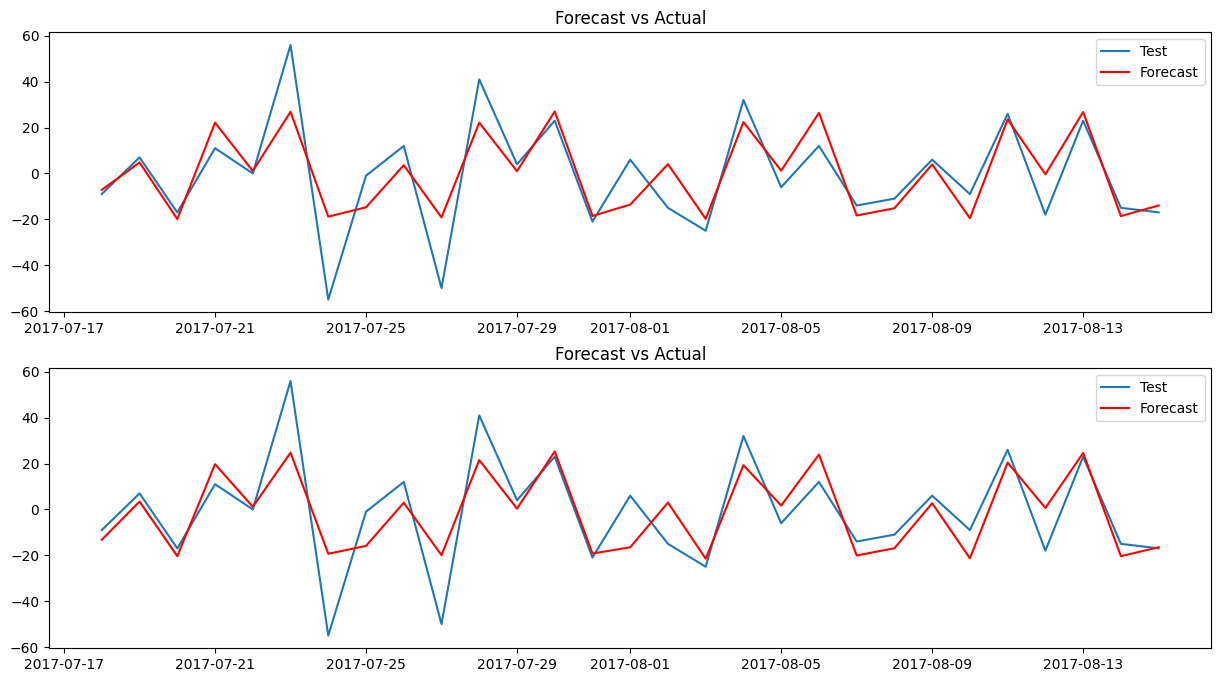

In [19]:
forecast1 = model_sarimax1_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test['onpromotion'], typ='levels')
forecast1.index = test.index

forecast2 = model_sarimax2_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test['dcoilwtico'], typ='levels')
forecast2.index = test.index

fig, ax = plt.subplots(2, 1, figsize=(15,8))

ax[0].set_title('Forecast vs Actual')  # Set judul untuk sumbu pertama
ax[0].plot(test['sales'], label='Test')
ax[0].plot(forecast1, label='Forecast', color='r')
ax[0].legend()

ax[1].set_title('Forecast vs Actual')  # Set judul untuk sumbu kedua
ax[1].plot(test['sales'], label='Test')
ax[1].plot(forecast2, label='Forecast', color='r')
ax[1].legend()

plt.show()

In [20]:
# check forecast row
SARIMAX1 = pd.DataFrame({'test': test['sales'], 'forecast': forecast1})
SARIMAX2 = pd.DataFrame({'test': test['sales'], 'forecast': forecast2})

In [21]:
model = [SARIMAX1, SARIMAX2]
model_name = ['SARIMAX (onpromotion)', 'SARIMAX (dcoilwtico)']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
SARIMAX (onpromotion),10.084337,190.486785,0.666421
SARIMAX (dcoilwtico),10.508227,200.795406,0.648368


# Ensemble Learning

In [22]:
# Ensembling
# Train multiple SARIMAX models
models = []
for exog in [train['onpromotion'], train['dcoilwtico']]:
    model = ARIMA(train['sales'], order=(2,1,2), seasonal_order=(2,1,2,7), exog=exog)
    model_fit = model.fit()
    models.append(model_fit)

# Combine predictions using ensemble method (e.g., averaging)
predictions = [model.predict(start=len(train), end=len(train) + len(test)-1, exog=test[exog.name]) for model, exog in zip(models, [train['onpromotion'], train['dcoilwtico']])]
ensemble_forecast = sum(predictions) / len(predictions)

In [23]:
def evaluate_forecast(y_train, y_pred):
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    return mae, mse, r2

# Buat model ARIMA untuk setiap variabel eksogen
models = []
for exog in [train['onpromotion'], train['dcoilwtico']]:
    model = ARIMA(train['sales'], order=(1,1,1), seasonal_order=(1,1,2,7), exog=exog)
    model_fit = model.fit()
    models.append(model_fit)

# Gabungkan prediksi menggunakan ensemble method (misalnya, averaging)
predictions = [model.predict(start=len(train), end=len(train) + len(test)-1, exog=test[exog.name]) for model, exog in zip(models, [train['onpromotion'], train['dcoilwtico']])]
ensemble_forecast = sum(predictions) / len(predictions)

# Evaluasi prediksi ensemble menggunakan metrik
ensemble = pd.DataFrame(evaluate_forecast(test['sales'], ensemble_forecast))

print("Ensemble Forecast Metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)

Ensemble Forecast Metrics:
MAE: 10.50822687949613
MSE: 200.7954061982401
R2: 0.6483684614222771


In [24]:
# Transpose DataFrame ensemble_forecast
ensemble_transposed = ensemble.T

# Ubah nama kolom menjadi nama index dari ensemble_forecast
ensemble_transposed.columns = ensemble.index

# Mengatur nama indeks dan nama kolom pada DataFrame ensemble_transposed
ensemble_transposed.index = ['Ensemble SARIMAX']
ensemble_transposed.columns = ['MAE', 'MSE', 'R2']

# Cetak DataFrame ensemble_transposed
ensemble_transposed

,MAE,MSE,R2
Ensemble SARIMAX,10.672297,206.305615,0.638719


In [25]:
merge = [metrics, ensemble_transposed]

sarimax = pd.concat(merge)
sarimax.sort_values(by = ['R2'], ascending = False)

,MAE,MSE,R2
SARIMAX (onpromotion),10.084337,190.486785,0.666421
SARIMAX (dcoilwtico),10.508227,200.795406,0.648368
Ensemble SARIMAX,10.672297,206.305615,0.638719
